<div style="background-color: #a7d9b6; color: black; padding: 20px">
  <h1 style="text-align: center"><strong>TPE Yann Inas 2023</strong></h1>
  <h2 style="text-align: center"><em>Détection de fraude bancaire</em></h2>
</div>

<!-- Pour le mode sombre -->

<style>
@media (prefers-color-scheme: dark) {
  div {
    background-color: #303030;
    color: white;
  }
}
</style>


# 1. Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix

import xgboost as xgb

In [2]:
DATA_x = pd.read_csv('data/X_train_G3tdtEn.csv', delimiter = ',',encoding = 'latin1', low_memory=False)
DATA_y = pd.read_csv('data/Y_train_2_XPXJDyy.csv', delimiter = ',',encoding = 'latin1', low_memory=False)

In [3]:
df_marques = pd.read_csv('data/df_make_save.csv', delimiter = ',',encoding = 'latin1', low_memory=False)
df_categs = pd.read_csv('data/df_categ_save.csv', delimiter = ',',encoding = 'latin1', low_memory=False)

In [4]:
df_marques = df_marques.drop("Unnamed: 0", axis=1).drop('nan',axis=1)
df_categs = df_categs.drop("Unnamed: 0", axis=1).drop('nan',axis=1)

# 2. Simplications des classes

On a vu dans le notebook "*categories.ipynb*" qu'on pouvait garder une trentaine de catégories, qui ont + de 10 achats et + de 1% de fraudes

In [5]:
achats_par_colonne = df_categs.sum()
x_achats = 10
colonnes_plus_de_x_achats = achats_par_colonne[achats_par_colonne > x_achats].index

# Sélectionner uniquement les colonnes qui ont plus de 10 achats
df_plus_de_x_achats = df_categs[colonnes_plus_de_x_achats]

merged_plus_x_achats = pd.merge(df_plus_de_x_achats,DATA_y,on='ID')
merged_plus_x_achats_fraud = merged_plus_x_achats[merged_plus_x_achats['fraud_flag'] == 1]

tab1 = merged_plus_x_achats_fraud.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum()
tab2 = merged_plus_x_achats.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum()
tab3 = 100 * tab1 / (tab1 + tab2)

categ_frauduleuses_pourcentage = tab3[tab3 > 1].index

df_less_categ = merged_plus_x_achats[categ_frauduleuses_pourcentage]
df_less_categ['ID'] = merged_plus_x_achats['ID']

df_less_categ = df_less_categ.fillna(0)

C:\Users\kille\AppData\Local\Temp\ipykernel_18892\1495732712.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_less_categ['ID'] = merged_plus_x_achats['ID']


On a vu dans le notebook "*marques.ipynb*" qu'on pouvait garder une trentaine de marques, qui ont + de 20 achats et + de 0.1% de fraudes

In [6]:
achats_par_colonne = df_marques.sum()
x_achats = 10
colonnes_plus_de_x_achats = achats_par_colonne[achats_par_colonne > x_achats].index

# Sélectionner uniquement les colonnes qui ont plus de 10 achats
df_plus_de_x_achats = df_marques[colonnes_plus_de_x_achats]

merged_plus_x_achats = pd.merge(df_plus_de_x_achats,DATA_y,on='ID')
merged_plus_x_achats_fraud = merged_plus_x_achats[merged_plus_x_achats['fraud_flag'] == 1]

tab1 = merged_plus_x_achats_fraud.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum()
tab2 = merged_plus_x_achats.drop("ID",axis=1).drop("index",axis=1).drop("fraud_flag",axis=1).sum()
tab3 = 100 * tab1 / (tab1 + tab2)

categ_frauduleuses_pourcentage = tab3[tab3 > 1].index

df_less_marques = merged_plus_x_achats[categ_frauduleuses_pourcentage]
df_less_marques['ID'] = merged_plus_x_achats['ID']

df_less_marques = df_less_marques.fillna(0)

C:\Users\kille\AppData\Local\Temp\ipykernel_18892\3602801688.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_less_marques['ID'] = merged_plus_x_achats['ID']


In [7]:
df_less_concat = pd.merge(df_less_categ,df_less_marques,on="ID")

In [8]:
df_less_concat['Nb_of_items'] = DATA_x['Nb_of_items']

cash_price_columns = ["cash_price" + str(i) for i in range(1, 5)]
X_cash_price = DATA_x[cash_price_columns]
df_less_concat = pd.concat([df_less_concat, X_cash_price], axis=1)
df_less_concat = df_less_concat.fillna(0)

In [9]:
df_less_concat.columns

Index(['AUDIO ACCESSORIES', 'BABY CHANGING', 'BABY CHILD TRAVEL',
       'BABY FEEDING', 'BABYWEAR', 'BARWARE', 'BLANK MEDIA MEDIA STORAGE',
       'CARPETS, RUGS & FLOORING', 'COMPUTERS', 'COOKWARE', 'FOOD PREPARATION',
       'FRAGRANCE', 'FULFILMENT CHARGE', 'GAMING', 'HI-FI',
       'HOME AND PERSONAL SECURITY', 'IMAGING EQUIPMENT', 'JEWELLERY WATCHES',
       'MEN S CLOTHES', 'MEN S FOOTWEAR', 'POWER BATTERIES', 'TABLEWARE',
       'TELEPHONES FAX MACHINES TWO-WAY RADIOS',
       'TELEPHONES, FAX MACHINES & TWO-WAY RADIOS', 'WOMEN S CLOTHES', 'ID',
       'ANGLEPOISE', 'APPLE', 'BT', 'BUGABOO', 'CHICCO', 'CYBEX', 'DELL',
       'DENBY', 'KARTELL', 'LE CREUSET', 'LEVI S', 'LOUIS DE POORTERE',
       'MAXI-COSI', 'NIKON', 'OXO', 'OYSTER', 'PANASONIC', 'PHILIPS',
       'RETAILER', 'RING', 'ROBERT WELCH', 'SAMSUNG', 'SHNUGGLE',
       'SILVER CROSS', 'TEMPUR', 'TOMMEE TIPPEE', 'Nb_of_items', 'cash_price1',
       'cash_price2', 'cash_price3', 'cash_price4'],
      dtype='object')

# 3. Test de modèles

In [11]:
avg_preci = []
confusion = []
for i in range(20):
    X_train, X_test, Y_train, Y_test = train_test_split(df_less_concat, DATA_y, test_size = 0.2)
    Y_train = Y_train.drop("ID",axis=1).drop("index",axis=1)
    Y_test = Y_test.drop("ID", axis=1).drop("index",axis=1)
    boost2 = xgb.XGBClassifier()
    boost2.fit(X_train, Y_train)
    y_pred2 = boost2.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred2).ravel()
    avg_preci.append(average_precision_score(Y_test, y_pred2))
    confusion.append((tn, fp, fn, tp))

In [12]:
print("Moyenne des average precision :", sum(avg_preci)/len(avg_preci))

Moyenne des average precision : 0.10225635698823184


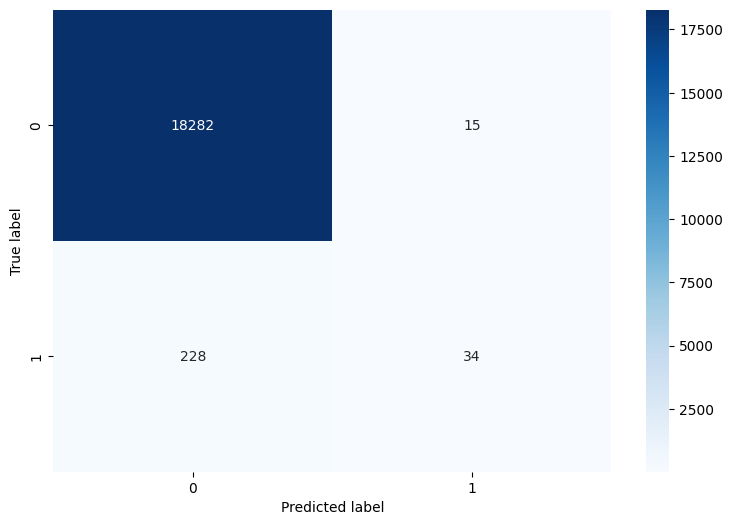

In [13]:
# Calculer la moyenne de chaque élément de la matrice de confusion
avg_confusion = np.mean(confusion, axis=0)

# Créer une matrice de confusion en utilisant la moyenne
confusion_array = np.array([[avg_confusion[0], avg_confusion[1]], [avg_confusion[2], avg_confusion[3]]])

# Créer une heatmap à partir de la matrice de confusion
plt.figure(figsize=(9,6))
sns.heatmap(confusion_array, annot=True, cmap='Blues', fmt=".0f")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Jouer avec les paramètres du XGBoost 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df_less_concat, DATA_y, test_size = 0.2, random_state=1)
Y_train = Y_train.drop("ID",axis=1).drop("index",axis=1)
Y_test = Y_test.drop("ID", axis=1).drop("index",axis=1)

NameError: name 'df_less_concat' is not defined

In [ ]:
X_train.to_csv("data/X_train.csv", sep=',',encoding = 'latin1')
Y_train.to_csv("data/Y_train.csv", sep=',',encoding = 'latin1')
X_test.to_csv("data/X_test.csv", sep=',',encoding = 'latin1')
Y_test.to_csv("data/Y_test.csv", sep=',',encoding = 'latin1')

In [ ]:
boost2 = xgb.XGBClassifier()
boost2.fit(X_train, Y_train)
y_pred2 = boost2.predict(X_test)

print(average_precision_score(Y_test, y_pred2))

0.13015677720976257


J'ai utilisé RandomGridCV mais sur Google Collab pour profiter du GPU. Les hyperparamètres suivant en découlent.

In [ ]:
best_boost = xgb.XGBClassifier(subsample=0.8, scale_pos_weight=1, reg_lambda=0.0, 
                               reg_alpha=0.6, n_estimators=750, min_child_weight=7, 
                               max_depth=8, learning_rate=0.1, gamma=0.2, 
                               colsample_bytree=0.9)
best_boost.fit(X_train, Y_train)
y_pred2 = best_boost.predict(X_test)

print(average_precision_score(Y_test, y_pred2))

0.15726139817331086


Maintenant, si on fait pour plusieurs répartitions : 

In [ ]:
avg_preci2 = []
confusion2 = []
for i in range(20):
    X_train, X_test, Y_train, Y_test = train_test_split(df_less_concat, DATA_y, test_size = 0.2)
    Y_train = Y_train.drop("ID",axis=1).drop("index",axis=1)
    Y_test = Y_test.drop("ID", axis=1).drop("index",axis=1)
    best_boost = xgb.XGBClassifier(subsample=0.8, scale_pos_weight=1, reg_lambda=0.0, 
                               reg_alpha=0.6, n_estimators=750, min_child_weight=7, 
                               max_depth=8, learning_rate=0.1, gamma=0.2, 
                               colsample_bytree=0.9)
    best_boost.fit(X_train, Y_train)
    y_pred2 = best_boost.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred2).ravel()
    avg_preci2.append(average_precision_score(Y_test, y_pred2))
    confusion2.append((tn, fp, fn, tp))

In [ ]:
print("Moyenne des average precision :", sum(avg_preci2)/len(avg_preci2))

Moyenne des average precision : 0.11280074438578165


In [ ]:
avg_preci2 = []
confusion2 = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(df_less_concat, DATA_y, test_size = 0.2)
    Y_train = Y_train.drop("ID",axis=1).drop("index",axis=1)
    Y_test = Y_test.drop("ID", axis=1).drop("index",axis=1)
    best_boost = xgb.XGBClassifier(subsample=0.7, scale_pos_weight=1, reg_lambda=0.5, 
                               reg_alpha=0.3, n_estimators=500, min_child_weight=7, 
                               max_depth=10, learning_rate=0.2, gamma=0.1, 
                               colsample_bytree=0.6)
    best_boost.fit(X_train, Y_train)
    y_pred2 = best_boost.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred2).ravel()
    avg_preci2.append(average_precision_score(Y_test, y_pred2))
    confusion2.append((tn, fp, fn, tp))

In [ ]:
print("Moyenne des average precision :", sum(avg_preci2)/len(avg_preci2))

Moyenne des average precision : 0.11346912206159802


In [ ]:
avg_preci2 = []
confusion2 = []
for i in range(10):
    X_train, X_test, Y_train, Y_test = train_test_split(df_less_concat, DATA_y, test_size = 0.2)
    Y_train = Y_train.drop("ID",axis=1).drop("index",axis=1)
    Y_test = Y_test.drop("ID", axis=1).drop("index",axis=1)
    best_boost = xgb.XGBClassifier(subsample=0.85, scale_pos_weight=1, reg_lambda=0.8, 
                               reg_alpha=0.7, n_estimators=700, min_child_weight=4, 
                               max_depth=5, learning_rate=0.2, gamma=0.0, 
                               colsample_bytree=0.9)
    best_boost.fit(X_train, Y_train)
    y_pred2 = best_boost.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(Y_test, y_pred2).ravel()
    avg_preci2.append(average_precision_score(Y_test, y_pred2))
    confusion2.append((tn, fp, fn, tp))

In [ ]:
print("Moyenne des average precision :", sum(avg_preci2)/len(avg_preci2))

Moyenne des average precision : 0.1141845535613196


# Pré-traitement sur tout le X_test fourni par BNP Paribas

### On peut ignorer cette partie, c'est pour soumettre un fichier sur le site du challenge et être classé

Cependant, c'est un bon résumé de comment on construit notre dataframe simplifié

In [ ]:
df_x_test_origin = pd.read_csv("data/X_test_8skS2ey.csv", delimiter = ',',encoding = 'latin1', low_memory=False)

In [ ]:
tableau_categs_marques = ['AUDIO ACCESSORIES', 'BABY CHANGING', 'BABY CHILD TRAVEL',
       'BABY FEEDING', 'BABYWEAR', 'BARWARE', 'BLANK MEDIA MEDIA STORAGE',
       'CARPETS, RUGS & FLOORING', 'COMPUTERS', 'COOKWARE', 'FOOD PREPARATION',
       'FRAGRANCE', 'FULFILMENT CHARGE', 'GAMING', 'HI-FI',
       'HOME AND PERSONAL SECURITY', 'IMAGING EQUIPMENT', 'JEWELLERY WATCHES',
       'MEN S CLOTHES', 'MEN S FOOTWEAR', 'POWER BATTERIES', 'TABLEWARE',
       'TELEPHONES FAX MACHINES TWO-WAY RADIOS',
       'TELEPHONES, FAX MACHINES & TWO-WAY RADIOS', 'WOMEN S CLOTHES', 'ANGLEPOISE', 'APPLE', 'BT', 'BUGABOO', 'CHICCO', 'CYBEX', 'DELL',
       'DENBY', 'KARTELL', 'LE CREUSET', 'LEVI S', 'LOUIS DE POORTERE',
       'MAXI-COSI', 'NIKON', 'OXO', 'OYSTER', 'PANASONIC', 'PHILIPS',
       'RETAILER', 'RING', 'ROBERT WELCH', 'SAMSUNG', 'SHNUGGLE',
       'SILVER CROSS', 'TEMPUR', 'TOMMEE TIPPEE']

print(tableau_categs_marques)

['AUDIO ACCESSORIES', 'BABY CHANGING', 'BABY CHILD TRAVEL', 'BABY FEEDING', 'BABYWEAR', 'BARWARE', 'BLANK MEDIA MEDIA STORAGE', 'CARPETS, RUGS & FLOORING', 'COMPUTERS', 'COOKWARE', 'FOOD PREPARATION', 'FRAGRANCE', 'FULFILMENT CHARGE', 'GAMING', 'HI-FI', 'HOME AND PERSONAL SECURITY', 'IMAGING EQUIPMENT', 'JEWELLERY WATCHES', 'MEN S CLOTHES', 'MEN S FOOTWEAR', 'POWER BATTERIES', 'TABLEWARE', 'TELEPHONES FAX MACHINES TWO-WAY RADIOS', 'TELEPHONES, FAX MACHINES & TWO-WAY RADIOS', 'WOMEN S CLOTHES', 'ANGLEPOISE', 'APPLE', 'BT', 'BUGABOO', 'CHICCO', 'CYBEX', 'DELL', 'DENBY', 'KARTELL', 'LE CREUSET', 'LEVI S', 'LOUIS DE POORTERE', 'MAXI-COSI', 'NIKON', 'OXO', 'OYSTER', 'PANASONIC', 'PHILIPS', 'RETAILER', 'RING', 'ROBERT WELCH', 'SAMSUNG', 'SHNUGGLE', 'SILVER CROSS', 'TEMPUR', 'TOMMEE TIPPEE']


In [ ]:
nb_colonnes = 4
df_x_test_simp = pd.DataFrame(columns=tableau_categs_marques, index=df_x_test_origin.index)
df_x_test_simp['ID'] = df_x_test_origin['ID']

for row in df_x_test_origin.index:
    for i in range(1, nb_colonnes+1):
        marque = df_x_test_origin[f'make{i}'][row]
        categ = df_x_test_origin[f'make{i}'][row]
        nb_items = df_x_test_origin[f"Nbr_of_prod_purchas{i}"][row]

        if type(marque) == float: # Stop si valeur nulle
            break
        if type(categ) == float: # Stop si valeur nulle
            break
    
        make_column = f"{marque}"
        categ_column = f"{categ}"
        if make_column in df_x_test_simp.columns:
            df_x_test_simp[make_column][row] = nb_items
        if categ_column in df_x_test_simp.columns:
            df_x_test_simp[categ_column][row] = nb_items

df_x_test_simp = df_x_test_simp.fillna(0)

C:\Users\kille\AppData\Local\Temp\ipykernel_21712\3090591788.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_test_simp[make_column][row] = nb_items
C:\Users\kille\AppData\Local\Temp\ipykernel_21712\3090591788.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_test_simp[categ_column][row] = nb_items


In [ ]:
df_x_test_simp['Nb_of_items'] = df_x_test_origin['Nb_of_items']

cash_price_columns = ["cash_price" + str(i) for i in range(1, 5)]
X_cash_price = df_x_test_origin[cash_price_columns]
df_x_test_simp = pd.concat([df_x_test_simp, X_cash_price], axis=1)
df_x_test_simp = df_x_test_simp.fillna(0)

In [ ]:
df_less_concat = df_less_concat.reindex(columns=df_x_test_simp.columns)

In [ ]:
df_less_concat.to_csv("data/X_train_BNP_simplif.csv", sep=',',encoding = 'latin1')
df_x_test_simp.to_csv("data/X_test_BNP_simplif.csv", sep=',',encoding = 'latin1')

### Testons le chargement des DataFrames

In [ ]:
df_train = pd.read_csv("data/X_train_BNP_simplif.csv", delimiter = ',', encoding='latin1', index_col=0)
df_test = pd.read_csv("data/X_test_BNP_simplif.csv", delimiter = ',', encoding='latin1', index_col=0)

In [ ]:
df_test

,AUDIO ACCESSORIES,BABY CHANGING,BABY CHILD TRAVEL,BABY FEEDING,BABYWEAR,BARWARE,BLANK MEDIA MEDIA STORAGE,"CARPETS, RUGS & FLOORING",COMPUTERS,COOKWARE,...,SHNUGGLE,SILVER CROSS,TEMPUR,TOMMEE TIPPEE,ID,Nb_of_items,cash_price1,cash_price2,cash_price3,cash_price4
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,64707,1.0,399.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,63919,1.0,294.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,15664,1.0,929.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,6626,2.0,539.0,7.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,26766,1.0,2470.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23193,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,63474,2.0,499.0,17.0,0.0,0.0
23194,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,80438,1.0,1189.0,0.0,0.0,0.0
23195,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,29485,1.0,1649.0,0.0,0.0,0.0
23196,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,59838,2.0,369.0,40.0,0.0,0.0


In [ ]:
X = pd.read_csv("data/X_train_BNP_simplif.csv", delimiter = ',', encoding='latin1', index_col=0)
Y = pd.read_csv("data/Y_train_2_XPXJDyy.csv", delimiter = ',', encoding='latin1', index_col=0)

X_train = X.drop('ID',axis=1)
Y_train = Y.drop('ID',axis=1)

X_test = pd.read_csv("data/X_test_BNP_simplif.csv", delimiter = ',', encoding='latin1', index_col=0)
Y_exemple = pd.read_csv("data/Y_test_random_2.csv", delimiter = ',', encoding='latin1', index_col=0)

In [ ]:
best_boost = xgb.XGBClassifier(subsample=0.7, scale_pos_weight=1, reg_lambda=0.3, 
                               reg_alpha=0.4, n_estimators=850, min_child_weight=8, 
                               max_depth=7, learning_rate=0.05, gamma=0.5, 
                               colsample_bytree=0.95)

best_boost.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.95, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              n_estimators=850, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
X_test_sans_ID = X_test.drop('ID',axis=1)

In [ ]:
Y_pred = best_boost.predict(X_test_sans_ID)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

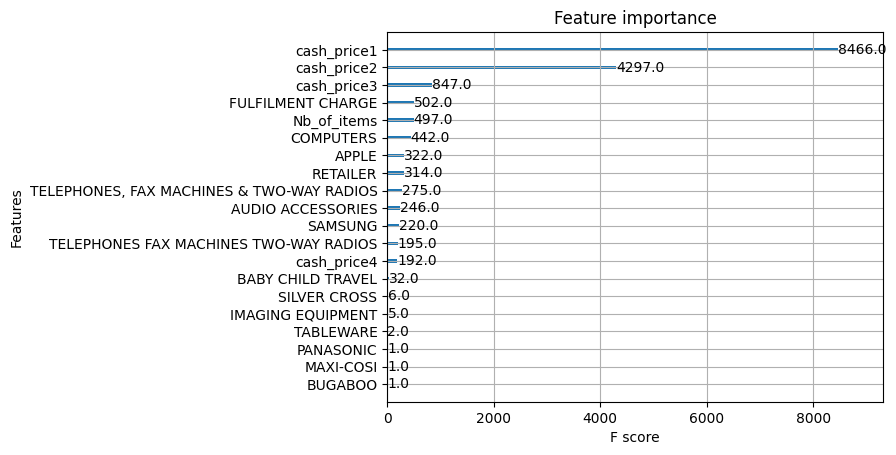

In [ ]:
xgb.plot_importance(best_boost)